In [8]:
import csv
import cv2
import numpy as np
import sklearn

samples = []
with open('../simulator_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
            
            # augment data
            augmented_images, augmented_angles = [], []
            for image, angle in zip(images, angles):
                augmented_images.append(image)
                augmented_angles.append(angle)
                augmented_images.append(cv2.flip(image,1))
                augmented_angles.append(angle*-1.0)

            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)

            yield sklearn.utils.shuffle(X_train, y_train)
            
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

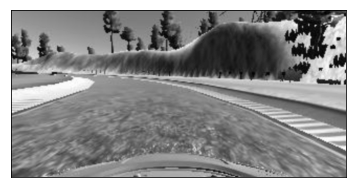

In [9]:
import matplotlib.pyplot as plt

img = cv2.imread('../simulator_data/IMG/center_2018_04_13_23_37_28_990.jpg',0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn.utils import shuffle

ch, row, col = 3, 90, 320  # Trimmed image format

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(160, col, ch)))
model.add(Cropping2D(cropping=((50,20), (0,0))))
model.add(Lambda(lambda x: x/255.0 - 0.5,
        input_shape=(1, row, col, ch)))
model.add(Convolution2D(3,1,1,border_mode = 'same', activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(32,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(128,3,3,activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(120))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss = 'mse',optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5)      
model.save('model.h5')



Epoch 1/5
14144/14148 [============================>.] - ETA: 2s - loss: 0.4214 

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


14208/14148 [==============================] - 8812s - loss: 0.4196 - val_loss: 0.0141
Epoch 2/5
14152/14148 [==============================] - 5314s - loss: 0.0169 - val_loss: 0.0157
Epoch 3/5
14208/14148 [==============================] - 3272s - loss: 0.0186 - val_loss: 0.0168
Epoch 4/5
14152/14148 [==============================] - 3410s - loss: 0.0176 - val_loss: 0.0160
Epoch 5/5
14208/14148 [==============================] - 3195s - loss: 0.0186 - val_loss: 0.0191


In [11]:
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

Epoch 1/5


KeyboardInterrupt: 